# Analysis of StackOverflow Survey. Part IV

In this notebook we address the third question, and we build a model to predict job satisfaction for data coders.

The steps of the process are: all steps with substeps
1. 
2. 

In [1]:
# general packages and libraries
import os
import sys
from collections import defaultdict
import importlib

In [2]:
# data manipulation packages
import numpy as np
import pandas as pd

In [3]:
# data visualizations packages
import matplotlib.pyplot as plt
# to render plots in the notebook
%matplotlib inline

import seaborn as sns
# set a theme for seaborn
sns.set_theme()

In [4]:
# clean this up in the end

from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn import (
    ensemble,
    preprocessing,
    tree,
)
from sklearn.model_selection import (
    train_test_split,
    StratifiedKFold,
)
from sklearn.metrics import (
    classification_report,
    r2_score, 
    mean_squared_error,
    auc,
    confusion_matrix,
    accuracy_score,
    roc_auc_score,
    roc_curve,
)


In [5]:
# import local module containing the neccessary functions
import utils_functions as uf
#import encoder_module as encm

# forces the interpreter to re-load the module
importlib.reload(uf);

# create a path string
mypath = os.getcwd()

## Formulate the questions

We separate the respondents of the 2020 StackOverflow Developer Survey into data developers
(data scientist or machine learning specialist, data or business analyst, data engineer) and other developers. In what follows we restrict the dataset to the data developers and address the following questions:  
 - What can we tell about the job satisfaction of a data developer? 
 - What factors do influence the job satisfaction? 
 
 We build a predictive model for the job satisfaction for data developers. This is a multi-class classification question, where the satisfaction levels are: very dissatisfied, slightly dissatisfied, neither satisfied nor dissatisfied, slightly satisfied, very satisfied.

## Performance metrics - to review at the end

The following performance measures will be used in this project:
1. Cross validation via StratifiedKFold with 10 folds.
2. Confusion matrix, in particular precision, recall and F1 score.
3. The ROC curve and the related AUC score.

# Gather and prepare the data

Upload the data and keep the subset that contains those developers that work in data science related fields. 


## Load the data

In [6]:
# upload the datafile as pandas dataframe
df = pd.read_csv(mypath+'/data/survey20_updated.csv', index_col=[0])
# check for success
df.shape

(64461, 61)

## Remove unnecessary data

In [7]:
# create a copy of the data
df1 = df.copy()

### Keep the developers that work with data

In [8]:
# change each string in DevType column into a list of strings
df1['DevType'] = df1['DevType'].str.split(';')

# check the outcome
df1.DevType.iloc[:3]

Respondent
1    [Developer, desktop or enterprise applications...
2           [Developer, full-stack, Developer, mobile]
3                                                  NaN
Name: DevType, dtype: object

In [9]:
# split a row with multiple choices strings in DevType into rows where
# DevType contains only one choice, the index is replicated 
df1=df1.explode('DevType')

# the new dataframe has many more rows now
df1.shape

(172185, 61)

In [10]:
# check the outcome
df1.DevType.iloc[:5]

Respondent
1    Developer, desktop or enterprise applications
1                            Developer, full-stack
2                            Developer, full-stack
2                                Developer, mobile
3                                              NaN
Name: DevType, dtype: object

In [11]:
# drop the rows with missing values in DevType column
df1.dropna(subset=['DevType'], inplace=True)

# check the outcome
df1.DevType.isnull().sum()

0

In [12]:
# retain only those rows that contain data coders
df1 = df1[df1['DevType'].str.contains('Data ')]

# check for success
df1.DevType.iloc[:5]

Respondent
22                                    Data engineer
25                                    Data engineer
30                         Data or business analyst
36                         Data or business analyst
36    Data scientist or machine learning specialist
Name: DevType, dtype: object

### Retain the developers that are employed

In [13]:
# check the employment types for data coders
df1.Employment.value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Not employed, but looking for work                       564
Employed part-time                                       469
Name: Employment, dtype: int64

In [14]:
# retain only the employed data developers
df1 = df1[df1['Employment'] != 'Not employed, but looking for work']

# check for success
df1.Employment.value_counts()

Employed full-time                                      9236
Independent contractor, freelancer, or self-employed    1481
Employed part-time                                       469
Name: Employment, dtype: int64

### Retain only the respondents that code professionally

In [15]:
# check the professional status of the employed developers
df1.MainBranch.value_counts()

I am a developer by profession                                                   8207
I am not primarily a developer, but I write code sometimes as part of my work    2275
I am a student who is learning to code                                            296
I used to be a developer by profession, but no longer am                          203
I code primarily as a hobby                                                       163
Name: MainBranch, dtype: int64

In [16]:
# create a list of main branch choices
main_choices = df1.MainBranch.value_counts().index.to_list()
# retain those rows where MainBranch contains the respondents that work professionally with data
df1 = df1[df1.MainBranch.isin(main_choices[:2])]

# check the outcome
df1.MainBranch.value_counts()

I am a developer by profession                                                   8207
I am not primarily a developer, but I write code sometimes as part of my work    2275
Name: MainBranch, dtype: int64

### Remove unnecessary columns

In [17]:
# list of columns to be removed
cols_del = [
    # personal, demographics  information
    #'Respondent', 
    'MainBranch', 'Employment', 'Hobbyist', 
    'Country','Ethnicity', 'Age',
    'Gender', 'Sexuality', 'Trans', 
    
    # related to ConvertedComp
    'CompFreq', 'CompTotal', 'CurrencyDesc', 'CurrencySymbol',
    
    # questions regarding future activities
    'DatabaseDesireNextYear', 'MiscTechDesireNextYear',
    'CollabToolsDesireNextYear', 'PlatformDesireNextYear',
    'LanguageDesireNextYear', 'WebframeDesireNextYear',
    
    # questions regarding this survey
    'SurveyEase', 'SurveyLength', 'WelcomeChange',
    
    # question regarding participation is StackOverflow
    'SOSites', 'SOComm', 'SOPartFreq',
    'SOVisitFreq', 'SOAccount',

    # columns related to other columns
    'Age1stCode', 'YearsCodePro', 'DevClass', 

    # high cardinality, multiple choices columns, add noise 
    'MiscTechWorkedWith', 'DatabaseWorkedWith',
    'WebframeWorkedWith', 'LanguageWorkedWith',

    # questions not relevant to our goal
    'JobHunt', 'JobHuntResearch', 'Stuck',
    'PurchaseResearch', 'PurchaseWhat', 
    'Stuck', 'PurpleLink',
    'OffTopic', 'OtherComms',
    'JobFactors', 'JobSeek',

    # auxiliary columns
    'DevClass']

In [18]:
# drop all the columns in the list
df1.drop(columns=cols_del, inplace=True)

# check the output
df1.shape

(10482, 17)

## Preprocess data

### Replace JobSat categories with numerical code and drop missing values

In [19]:
# drop rows with missing JobSat
#df1.dropna(subset=['JobSat'], inplace=True)

# the replacement codes in a dictionary
#replace_dict = {'Very dissatisfied': 1, 'Slightly dissatisfied': 2,
               #'Neither satisfied nor dissatisfied': 3, 
               #'Slightly satisfied': 4, 'Very satisfied': 5}

#  encode the 'JobSat' data to numerical values
#df1['JobSat'] = df1['JobSat'].replace(replace_dict)

# check for success
#print(df1['JobSat'].value_counts())

### Update YearsCode column entries and dtype

In [20]:
# replace strings with numerical entries
replace_dict = {'Less than 1 year': '0', 'More than 50 years': '51'}
df1.replace(replace_dict, inplace=True)

# change dtype to numeric
df1['YearsCode'] = pd.to_numeric(df1['YearsCode'])

### Replace multiple choices strings with single choice rows

In [21]:
multi_cols = ['CollabToolsWorkedWith','PlatformWorkedWith']

# explode the two columns
for col in multi_cols:
    df1 = uf.explode_col(df1, col)
    
# check the outcome
df1.shape

(165031, 17)

### Review data types and data distribution in columns

In [47]:
# the list of numerical columns
num_cols = df1.select_dtypes(include='float64').columns.to_list()
print(num_cols)

['ConvertedComp', 'WorkWeekHrs', 'YearsCode']


In [67]:
# the list of all categorical columns
cat_cols = X.select_dtypes(include='object').columns.to_list()
print(cat_cols)

['DevType', 'EdLevel', 'CollabToolsWorkedWith', 'DevOps', 'DevOpsImpt', 'EdImpt', 'Learn', 'OnboardGood', 'Overtime', 'OpSys', 'OrgSize', 'PlatformWorkedWith', 'UndergradMajor']


In [68]:
# further divide the categorical columns in
multi_cols = ['CollabToolsWorkedWith', 'PlatformWorkedWith']
uni_cols = list(set(cat_cols) - set(multi_cols))
print(uni_cols)

['DevOps', 'Overtime', 'Learn', 'OnboardGood', 'DevType', 'OrgSize', 'EdLevel', 'EdImpt', 'OpSys', 'DevOpsImpt', 'UndergradMajor']


In [69]:
# for each categorical column, print possible row values and their counts
def list_answers(df, cat_cols):
    for col in cat_cols:
        print(col)
        print(' ')
        print(df1[col].value_counts())
        print(' ')
# print counts and values
#list_answers(df1, all_cat_cols)

Comments:  

All the categorical columns have unique strings as entries. So, at this point we can use one of the encoding methods from sklearn.

### Remove duplicates

In [26]:
# drop duplicate rows, if any
df1.drop_duplicates(subset=None, keep='first', inplace=True)
df1.shape

(164940, 17)

## Refactor code

Rewrite all of the steps for data pre-processing in a single function.

In [27]:
# create a fresh copy of the dataset
dft=df.copy()

In [28]:
# all data cleaning and preprocessing steps
dft = uf.remove_clean_data(dft)
# check the outcome
dft.shape

(163969, 17)

## Sample data, create features and target datasets

Create a dataframe X of features and a pandas series y that contains the labels.

In [70]:
# create a copy of the pre-processed dataframe
df2 = df1.copy()

In [71]:
# create the predictors dataframe
X = df2.drop(columns = 'JobSat')

# create the labels
y = df2['JobSat']

# check for success
X.shape, len(y)

((164940, 16), 164940)

### Isolate a test set

In [72]:
# split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# summarize the data
print('Train', X_train.shape, y_train.shape)
print('Test', X_test.shape, y_test.shape)

Train (115458, 16) (115458,)
Test (49482, 16) (49482,)


## Impute the missing values

In [73]:
# take the numerical columns in the train dataset
X_train_num = X_train[num_cols]
# create an instance of the KNN imputer
num_imputer = KNNImputer(n_neighbors=5)
# fit_transform the imputer on the training set
X_train_num_imp = pd.DataFrame(num_imputer.fit_transform(X_train_num), 
                               columns=X_train_num.columns)
# separate the numerical columns in the test set
X_test_num = X_test[num_cols]
# transform the test set with the imputer that was fit on the training set
X_test_num_imp = pd.DataFrame(num_imputer.transform(X_test_num), columns=X_test_num.columns)

In [99]:
# create an instance of the scaler
scaler = StandardScaler()

# scale the numerical variables, fit and transform on the straining set
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_num_imp), 
                                columns=X_train_num_imp.columns)
# use the scaler fit on training set to transform the test set
X_test_scaled = pd.DataFrame(scaler.transform(X_test_num_imp), columns=X_test_num_imp.columns)
     

In [75]:
# separate all the categorical columns in the training set
X_train_cat = X_train[cat_cols]
# create an instance of the imputer
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
# fit and transform the training data
X_train_cat_imp = pd.DataFrame(cat_imputer.fit_transform(X_train_cat), 
                               columns=X_train_cat.columns)
# separate the categorical columns in the test set
X_test_cat = X_test[cat_cols]
# transform the test data with the imputer fit on the training set
X_test_cat_imp=pd.DataFrame(cat_imputer.transform(X_test_cat), columns=X_test_cat.columns)

In [92]:
# encode the low cardinality columns
def ord_encode_predictors(X_train, X_test):
    oe = OrdinalEncoder()
    oe.fit(X_train)
    X_train_enc = pd.DataFrame(oe.transform(X_train))
    X_test_enc = pd.DataFrame(oe.transform(X_test))
    return X_train_enc, X_test_enc

In [93]:
# the low cardinality features
X_train_uni_enc, X_test_uni_enc = ord_encode_predictors(X_train_cat_imp[uni_cols], X_test_cat_imp[uni_cols])

In [87]:
# encode the high cardinality columns
def encode_predictors(X_train, X_test):
    enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
    enc.fit(X_train)
    X_train_enc = pd.DataFrame(enc.transform(X_train))
    X_test_enc = pd.DataFrame(enc.transform(X_test))
    return X_train_enc, X_test_enc

In [94]:
# the low cardinality features
X_train_multi_enc, X_test_multi_enc = encode_predictors(X_train_cat_imp[multi_cols], X_test_cat_imp[multi_cols])

In [90]:
# encode the target variable
def encode_targets(y_train, y_test):
	le = LabelEncoder()
	le.fit(y_train)
	y_train_enc = le.transform(y_train)
	y_test_enc = le.transform(y_test)
	return y_train_enc, y_test_enc

In [91]:
# encode the target variable
y_train_enc, y_test_enc = encode_targets(y_train,y_test)

In [100]:
# combine the  X frames 
X_train_cat_enc = pd.concat([X_train_multi_enc, X_train_uni_enc], axis=1)
X_train_prep = pd.concat([X_train_cat_enc, X_train_scaled], axis=1)

X_test_cat_enc = pd.concat([X_test_multi_enc, X_test_uni_enc], axis=1)
X_test_prep = pd.concat([X_test_cat_enc, X_test_scaled], axis=1)


In [104]:
y_train_enc

array([1, 4, 4, ..., 1, 2, 4])

In [105]:
# feature selection
def select_features(X_train, y_train, X_test):
	fs = SelectKBest(score_func=mutual_info_classif, k=20)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return X_train_fs, X_test_fs, fs

In [108]:
X_train_fs, X_test_fs, fs = select_features(X_train_prep, y_train_enc, X_test_prep)

In [126]:
df_sample = df.groupby('JobSat', group_keys=False).apply(
    lambda x: x.sample(frac=0.3, replace=False, random_state=42))

In [127]:
def cal_mutual_info(df, target_var=None, disc_features_only=True):
    """Calculate mutual information for feature selection, based on mutual_info_classif from sklearn.feature_selection.
    :param df: Pandas dataframe
    :param target_var: target variable
    :param disc_features_only: boolean, calculate mutual information for discrete feature only
    :return:
        a Pandas dataframe with mutual information for features
    """
    df = df.copy()

    df_f_type = df.dtypes
    df_f_type = df_f_type.loc[~df_f_type.index.isin([target_var])].copy()
    cols_if_num = df_f_type.apply(lambda x: np.issubdtype(x, np.number))
    discrete_f = ~cols_if_num
    # get all categorical features
    cols_num = cols_if_num[cols_if_num].index.tolist()
    cols_cat = cols_if_num[~cols_if_num].index.tolist()

    for col_cat in cols_cat:
        df[col_cat] = df[col_cat].fillna('Missing')

    for col_num in cols_num:
        df[col_num] = df[col_num].fillna(df[col_num].mean())

    enc = OrdinalEncoder()
    df[cols_cat] = enc.fit_transform(df[cols_cat])
    enc = OrdinalEncoder()
    df.loc[:, target_var] = enc.fit_transform(df[[target_var]])

    if not disc_features_only:
        all_features = df_f_type.index.tolist()
        mutual_info = mutual_info_classif(df[all_features], df[target_var].values,
                                          discrete_features=discrete_f,
                                          n_neighbors=20,
                                          random_state=123)
        df_mutual_info = pd.DataFrame(data=zip(all_features, mutual_info), columns=['columns', 'mutual_info'])
        return df_mutual_info
    else:

        mutual_info = mutual_info_classif(df[cols_cat], df[target_var].values,
                                          discrete_features=True)
        df_mutual_info = pd.DataFrame(data=zip(cols_cat, mutual_info), columns=['columns', 'mutual_info'])
        return df_mutual_info

In [132]:
multiple = [
    'DatabaseDesireNextYear', 'MiscTechDesireNextYear',
    'CollabToolsDesireNextYear', 'PlatformDesireNextYear',
    'LanguageDesireNextYear', 'WebframeDesireNextYear',
    'MiscTechWorkedWith', 'DatabaseWorkedWith',
    'WebframeWorkedWith', 'LanguageWorkedWith',
    'CollabToolsWorkedWith', 'PlatformWorkedWith']

   

In [134]:
df_f_mutual_info = cal_mutual_info(df_sample.drop(multiple, axis=1), target_var='JobSat', disc_features_only=False)

In [135]:
df_f_mutual_info

,columns,mutual_info
0,MainBranch,0.000086
1,Hobbyist,0.000502
2,Age,0.007715
3,Age1stCode,0.010964
4,CompFreq,0.005972
5,CompTotal,0.002975
6,ConvertedComp,0.014892
7,Country,0.043485
8,CurrencyDesc,0.036236
9,CurrencySymbol,0.036236


In [136]:
df_f_mutual_info[df_f_mutual_info['mutual_info'] > 0.005]

,columns,mutual_info
2,Age,0.007715
3,Age1stCode,0.010964
4,CompFreq,0.005972
6,ConvertedComp,0.014892
7,Country,0.043485
8,CurrencyDesc,0.036236
9,CurrencySymbol,0.036236
10,DevType,0.380142
13,Ethnicity,0.024971
15,JobFactors,0.040776


<BarContainer object of 43 artists>

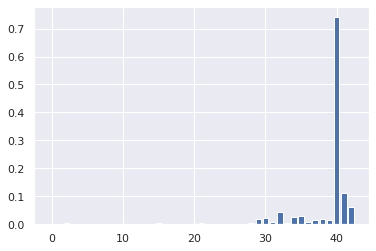

In [117]:
#plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)

### Create a profiling report

In [44]:
# run this once to generate a profiling report and save it as html file

#import pandas_profiling
#profile = pandas_profiling.ProfileReport(X_train, minimal=False)
#profile.to_file(output_file="data_train_report.html")

## Impute the missing values

In [45]:
# create a copy of the train set
Xt = X_train.copy()

In [46]:
# the numerical columns subset
Xt_num = Xt[num_cols]
Xt_num.isnull().sum()

ConvertedComp    6173
WorkWeekHrs      2418
YearsCode         157
dtype: int64

In [47]:
# create an instance of the imputer
num_imputer = KNNImputer(n_neighbors=5)
# impute the missing numerical values
Xt_num_imp= pd.DataFrame(num_imputer.fit_transform(Xt_num), columns=Xt_num.columns)

# check the outcome
Xt_num_imp.isnull().sum()

ConvertedComp    0
WorkWeekHrs      0
YearsCode        0
dtype: int64

In [48]:
# the categorical columns subset
Xt_cat = Xt[cat_cols]
Xt_cat.isnull().sum()

DevType                  0
EdLevel                374
DevOps                1033
DevOpsImpt            1372
EdImpt                 467
Learn                 1078
OnboardGood           1064
Overtime               842
OpSys                  851
OrgSize                537
PlatformWorkedWith     701
UndergradMajor        1915
dtype: int64

In [49]:
# create an instance of the imputer
cat_imputer = SimpleImputer(strategy='constant', fill_value='missing')
# impute the missing categorical values
Xt_cat_imp = pd.DataFrame(cat_imputer.fit_transform(Xt_cat), columns=Xt_cat.columns)

# check for success
Xt_cat_imp.isnull().sum()

DevType               0
EdLevel               0
DevOps                0
DevOpsImpt            0
EdImpt                0
Learn                 0
OnboardGood           0
Overtime              0
OpSys                 0
OrgSize               0
PlatformWorkedWith    0
UndergradMajor        0
dtype: int64

## Encode the categorical variables

In [50]:
# create dummies for the categorical variables

def encode_predictors(X_train): #X_test
	enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
	enc.fit(X_train)
	X_train_enc = pd.DataFrame(enc.transform(X_train))
    #X_test_enc = enc.transform(X_test)
	return X_train_enc#, X_test_enc

In [51]:
Xt_enc = encode_predictors(Xt_cat_imp)

## Scale the numerical variables

In [52]:
# create an instance of the scaler
scaler = StandardScaler()

# scale the numerical variables
Xt_scaled = pd.DataFrame(scaler.fit_transform(Xt_num_imp), columns=Xt_num.columns)

# check the outcome
Xt_scaled.head()

,ConvertedComp,WorkWeekHrs,YearsCode
0,2.404268,0.016779,-1.303475
1,-0.439017,-0.754697,0.255928
2,-0.441597,-0.161254,-0.523774
3,-0.350753,-0.161254,-0.718699
4,-0.276874,0.432189,-0.621236


In [53]:
# combine the categorical and the numerical columns
Xt_prep = pd.concat([Xt_scaled, Xt_enc], axis=1)

# check the outcome
Xt_prep.head()

,ConvertedComp,WorkWeekHrs,YearsCode,0,1,2,3,4,5,6,...,79,80,81,82,83,84,85,86,87,88
0,2.404268,0.016779,-1.303475,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.439017,-0.754697,0.255928,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.441597,-0.161254,-0.523774,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.350753,-0.161254,-0.718699,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.276874,0.432189,-0.621236,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Refactor the code: build processing data pipeline

In [54]:
## refactor code: processing data

# the steps in the categorical pipeline
cat_pipeline = Pipeline( steps = [( 'cat_selector', uf.FeatureSelector(cat_cols) ),
                                  ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                  ( 'one_hot_encoder', OneHotEncoder(sparse=False) ) ] )
    
# defining the steps in the numerical pipeline     
num_pipeline = Pipeline( steps = [ ( 'num_selector', uf.FeatureSelector(num_cols) ),
                                  ('imputer', KNNImputer(n_neighbors=5) ),
                                  ( 'std_scaler', StandardScaler() ) ] )

# combine the numerical and the categorical pipelines
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', cat_pipeline ), 
                                                  ( 'numerical_pipeline', num_pipeline ) ] )

# Baseline model

In [55]:
# the full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                  ( 'model', KNeighborsClassifier(n_neighbors=5) ) ] )

# call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

# predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test ) 

In [56]:
# print evaluation metrics and results

result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)
         

Confusion Matrix:
[[ 728   24   30   51   80]
 [  20 1330   32  104  108]
 [  30   54 1120   86   89]
 [  46  135   94 2640  241]
 [  65  107   77  291 3526]]

Classification Report:
              precision    recall  f1-score   support

           1       0.82      0.80      0.81       913
           2       0.81      0.83      0.82      1594
           3       0.83      0.81      0.82      1379
           4       0.83      0.84      0.83      3156
           5       0.87      0.87      0.87      4066

    accuracy                           0.84     11108
   macro avg       0.83      0.83      0.83     11108
weighted avg       0.84      0.84      0.84     11108

Accuracy: 0.841


In [60]:
# the full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                  ( 'model', xgb.XGBClassifier(objective = 'binary:logistic') ) ] )

# call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

# predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test ) 

In [61]:
# print evaluation metrics and results

result1 = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(result1)

result2 = classification_report(y_test, y_pred)
print('\nClassification Report:')
print (result2)

result3 = accuracy_score(y_test,y_pred)  
print('Accuracy: %.3f' %result3)

Confusion Matrix:
[[  87   26    9  280  511]
 [   5  217    8  661  703]
 [   1   42  176  528  632]
 [   1   71   12 1423 1649]
 [   1   68   16  619 3362]]

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.10      0.17       913
           2       0.51      0.14      0.22      1594
           3       0.80      0.13      0.22      1379
           4       0.41      0.45      0.43      3156
           5       0.49      0.83      0.62      4066

    accuracy                           0.47     11108
   macro avg       0.62      0.33      0.33     11108
weighted avg       0.54      0.47      0.42     11108

Accuracy: 0.474


In [71]:
from sklearn import model_selection
from sklearn.linear_model import (LogisticRegression)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import (KNeighborsClassifier)
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import (RandomForestClassifier)
import xgboost as xgb
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from scipy import stats
from sklearn.model_selection import KFold

In [62]:
for model in [DecisionTreeClassifier, KNeighborsClassifier, GaussianNB, SVC, 
              RandomForestClassifier, SGDClassifier]:
    make_pipeline(model())
    classifier = model()
    kfold = model_selection.KFold(n_splits=5)
    classifier.fit(X_train_prep, y_train)
    s = model_selection.cross_val_score(classifier, X_test_prep,y_test, cv=kfold)
    #result2 = classification_report(y_test, y_pred, zero_division=0)
    #s = model_selection.cross_val_score(cls, X, y, cv=kfold)
    print(f"{model.__name__:22}  CV_Mean:" f"{s.mean():.3f} CV_STD: {s.std():.2f}")

DecisionTreeClassifier  CV_Mean:0.755 CV_STD: 0.00
KNeighborsClassifier    CV_Mean:0.607 CV_STD: 0.00
GaussianNB              CV_Mean:0.214 CV_STD: 0.03
SVC                     CV_Mean:0.535 CV_STD: 0.01
RandomForestClassifier  CV_Mean:0.818 CV_STD: 0.01
SGDClassifier           CV_Mean:0.364 CV_STD: 0.01


In [80]:
clf_xgb = RandomForestClassifier()
param_dist = {'n_estimators': stats.randint(150, 1000),
              'learning_rate': stats.uniform(0.01, 0.59),
              'subsample': stats.uniform(0.3, 0.6),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': stats.uniform(0.5, 0.4),
              'min_child_weight': [1, 2, 3, 4]
             }

numFolds = 5
n = X_train_prep.shape[0]
kfold_5 = KFold(n, True, 5)

clf = RandomizedSearchCV(clf_xgb, 
                         param_distributions = param_dist,
                         cv = kfold_5,  
                         n_iter = 5, # you want 5 here not 25 if I understand you correctly 
                         scoring = 'roc_auc', 
                         error_score = 0, 
                         verbose = 3, 
                         n_jobs = -1)

In [81]:
def hyperparameter_tune(base_model, parameters, n_iter, kfold, X=X_train, y=y_train):
    start_time = time.time()
    
    # Arrange data into folds with approx equal proportion of classes within each fold
    k = StratifiedKFold(n_splits=kfold, shuffle=False)
    
    optimal_model = RandomizedSearchCV(base_model,
                            param_distributions=parameters,
                            n_iter=n_iter,
                            cv=k,
                            n_jobs=-1,
                            random_state=42)
    optimal_model.fit(X, y)
    
    stop_time = time.time()

    scores = cross_val_score(optimal_model, X, y, cv=k, scoring="accuracy")
    
    print("Elapsed Time:", time.strftime("%H:%M:%S", time.gmtime(stop_time - start_time)))
    print("====================")
    print("Cross Val Mean: {:.3f}, Cross Val Stdev: {:.3f}".format(scores.mean(), scores.std()))
    print("Best Score: {:.3f}".format(optimal_model.best_score_))
    print("Best Parameters: {}".format(optimal_model.best_params_))
    
    return optimal_model.best_params_, optimal_model.best_score_

In [82]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from scipy.stats import randint
import matplotlib.pyplot as plt
import time
import warnings
warnings.simplefilter("ignore", category=PendingDeprecationWarning)
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=UserWarning)

In [83]:
base_model = RandomForestClassifier(n_jobs=-1,
                                   random_state=42)

lots_of_parameters = {
    "max_depth": [3, 5, 10, None],
    "n_estimators": [100, 200, 300, 400, 500],
    "max_features": randint(1, 3),
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
    "min_samples_leaf": randint(1, 4)
}

parameters = {
    "max_depth": [3, 5, 10, None],
    "n_estimators": [100, 200, 300, 400, 500]
}

best_params, best_score = hyperparameter_tune(base_model, parameters, 10, 5, X_train_prep, y_train)

Elapsed Time: 00:00:38
Cross Val Mean: 0.931, Cross Val Stdev: 0.005
Best Score: 0.930
Best Parameters: {'n_estimators': 200, 'max_depth': None}


In [84]:
rf = RandomForestClassifier(n_estimators=200)
rf.fit(X_train_prep, y_train)

RandomForestClassifier(n_estimators=200)

In [ ]:
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test_prep)

In [ ]:
shap.summary_plot(shap_values, X_test_prep, plot_type="bar")

In [139]:
df_f_type = df.dtypes

In [143]:
df_f_type = df_f_type.loc[~df_f_type.index.isin(['JobSat'])]

In [144]:
cols_if_num = df_f_type.apply(lambda x: np.issubdtype(x, np.number))

In [146]:
cols_if_num.sum()

4

In [147]:
cols_cat = cols_if_num[~cols_if_num].index.tolist()

In [148]:
cols_cat

['MainBranch',
 'Hobbyist',
 'Age1stCode',
 'CompFreq',
 'Country',
 'CurrencyDesc',
 'CurrencySymbol',
 'DatabaseDesireNextYear',
 'DatabaseWorkedWith',
 'DevType',
 'EdLevel',
 'Employment',
 'Ethnicity',
 'Gender',
 'JobFactors',
 'JobSeek',
 'LanguageDesireNextYear',
 'LanguageWorkedWith',
 'MiscTechDesireNextYear',
 'MiscTechWorkedWith',
 'CollabToolsDesireNextYear',
 'CollabToolsWorkedWith',
 'DevOps',
 'DevOpsImpt',
 'EdImpt',
 'JobHunt',
 'JobHuntResearch',
 'Learn',
 'OffTopic',
 'OnboardGood',
 'OtherComms',
 'Overtime',
 'PurchaseResearch',
 'PurpleLink',
 'SOSites',
 'Stuck',
 'OpSys',
 'OrgSize',
 'PlatformDesireNextYear',
 'PlatformWorkedWith',
 'PurchaseWhat',
 'Sexuality',
 'SOAccount',
 'SOComm',
 'SOPartFreq',
 'SOVisitFreq',
 'SurveyEase',
 'SurveyLength',
 'Trans',
 'UndergradMajor',
 'WebframeDesireNextYear',
 'WebframeWorkedWith',
 'WelcomeChange',
 'YearsCode',
 'YearsCodePro',
 'DevClass']

In [157]:
for col_cat in cols_cat:
        df_sample[col_cat] = df_sample[col_cat].fillna('missing')

In [158]:
df_sample[cols_cat].isnull().sum()

MainBranch                   0
Hobbyist                     0
Age1stCode                   0
CompFreq                     0
Country                      0
CurrencyDesc                 0
CurrencySymbol               0
DatabaseDesireNextYear       0
DatabaseWorkedWith           0
DevType                      0
EdLevel                      0
Employment                   0
Ethnicity                    0
Gender                       0
JobFactors                   0
JobSeek                      0
LanguageDesireNextYear       0
LanguageWorkedWith           0
MiscTechDesireNextYear       0
MiscTechWorkedWith           0
CollabToolsDesireNextYear    0
CollabToolsWorkedWith        0
DevOps                       0
DevOpsImpt                   0
EdImpt                       0
JobHunt                      0
JobHuntResearch              0
Learn                        0
OffTopic                     0
OnboardGood                  0
OtherComms                   0
Overtime                     0
Purchase

In [160]:
cols_num = cols_if_num[cols_if_num].index.tolist()
cols_num

['Age', 'CompTotal', 'ConvertedComp', 'WorkWeekHrs']

In [161]:
for col_num in cols_num:
        df_sample[col_num] = df_sample[col_num].fillna(df[col_num].mean())

In [162]:
df_sample[cols_num].isnull().sum()

Age              0
CompTotal        0
ConvertedComp    0
WorkWeekHrs      0
dtype: int64

In [159]:
enc = OrdinalEncoder()
df_sample[cols_cat] = enc.fit_transform(df_sample[cols_cat])

In [163]:
enc = OrdinalEncoder()
df_sample.loc[:, 'JobSat'] = enc.fit_transform(df_sample[['JobSat']])

In [166]:
df_sample['JobSat']

Respondent
18657    0.0
20529    0.0
32963    0.0
43959    0.0
1912     0.0
        ... 
32979    4.0
47032    4.0
5262     4.0
37419    4.0
6479     4.0
Name: JobSat, Length: 13558, dtype: float64